初始化spark环境

In [6]:
import findspark
findspark.init()

In [7]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession # SparkSession 是Spark 2.0版本的新入口
spark = SparkSession.builder.master('local').getOrCreate()

In [54]:
# 加载 utils.py 中的自定义方法
from utils import *

In [55]:
preAndRec?

In [8]:
# 使能调用其他 ipynb 文件
# import ipynb_importer 

# 特征工程

* DataFrame操作 https://blog.csdn.net/sinat_26917383/article/details/80500349 
* DataFrame基础 https://zhuanlan.zhihu.com/p/34901683
* 处理稀疏特征 http://www.4o4notfound.org/index.php/archives/123/
* 用户自定义函数 https://stackoverflow.com/questions/29109916/updating-a-dataframe-column-in-spark

TODO: 从 hive 中读取数据

In [9]:
# TODO：从 hive 中读取

设置schema

In [10]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

In [11]:
schema = StructType([
StructField("duration",IntegerType(),False),
StructField("protocol_type",StringType(),False),
StructField("service",StringType(),False),
StructField("flag",StringType(),False),
StructField("src_bytes",IntegerType(),False),
StructField("dst_bytes",IntegerType(),False),
StructField("land",IntegerType(),False),
StructField("wrong_fragment",IntegerType(),False),
StructField("urgent",IntegerType(),False),
StructField("hot",IntegerType(),False),
StructField("num_failed_logins",IntegerType(),False),
StructField("logged_in",IntegerType(),False),
StructField("num_compromised",IntegerType(),False),
StructField("root_shell",IntegerType(),False),
StructField("su_attempted",IntegerType(),False),
StructField("num_root",IntegerType(),False),
StructField("num_file_creations",IntegerType(),False),
StructField("num_shells",IntegerType(),False),
StructField("num_access_files",IntegerType(),False),
StructField("num_outbound_cmds",IntegerType(),False),
StructField("is_host_login",IntegerType(),False),
StructField("is_guest_login",IntegerType(),False),
StructField("count",IntegerType(),False),
StructField("srv_count",IntegerType(),False),
StructField("serror_rate",FloatType(),False),
StructField("srv_serror_rate",FloatType(),False),
StructField("rerror_rate",FloatType(),False),
StructField("srv_rerror_rate",FloatType(),False),
StructField("same_srv_rate",FloatType(),False),
StructField("diff_srv_rate",FloatType(),False),
StructField("srv_diff_host_rate",FloatType(),False),
StructField("dst_host_count",IntegerType(),False),
StructField("dst_host_srv_count",IntegerType(),False),
StructField("dst_host_same_srv_rate",FloatType(),False),
StructField("dst_host_diff_srv_rate",FloatType(),False),
StructField("dst_host_same_src_port_rate",FloatType(),False),
StructField("dst_host_srv_diff_host_rate",FloatType(),False),
StructField("dst_host_serror_rate",FloatType(),False),
StructField("dst_host_srv_serror_rate",FloatType(),False),
StructField("dst_host_rerror_rate",FloatType(),False),
StructField("dst_host_srv_rerror_rate",FloatType(),False),
StructField("label",StringType(),False)
])

从本地读取数据

In [12]:
# 从csv中读取
dataset = spark.read.csv('Data/kddcup.data_10_percent.gz', header=None,schema=schema)
dataset.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

合并稀疏特征

In [13]:
from utils import mapper_mergeSparseFeatureInService
import pyspark.sql.functions as F

In [14]:
# 用户自定义函数
udf_mergeSparseFeatureInService = F.UserDefinedFunction(mapper_mergeSparseFeatureInService,StringType())

In [15]:
dataset = dataset.select(
    *[udf_mergeSparseFeatureInService(column).alias('service') if column == 'service' else column for column in dataset.columns]
)
dataset.select('service').show(2)

+-------+
|service|
+-------+
|   http|
|   http|
+-------+
only showing top 2 rows



In [16]:
set(dataset.select('service').collect())

{Row(service='IRC'),
 Row(service='X11'),
 Row(service='Z39_50'),
 Row(service='auth'),
 Row(service='bgp'),
 Row(service='courier'),
 Row(service='csnet_ns'),
 Row(service='ctf'),
 Row(service='daytime'),
 Row(service='discard'),
 Row(service='domain'),
 Row(service='domain_u'),
 Row(service='echo'),
 Row(service='eco_i'),
 Row(service='ecr_i'),
 Row(service='efs'),
 Row(service='exec'),
 Row(service='finger'),
 Row(service='ftp'),
 Row(service='ftp_data'),
 Row(service='gopher'),
 Row(service='hostnames'),
 Row(service='http'),
 Row(service='http_443'),
 Row(service='imap4'),
 Row(service='iso_tsap'),
 Row(service='klogin'),
 Row(service='kshell'),
 Row(service='ldap'),
 Row(service='link'),
 Row(service='login'),
 Row(service='mtp'),
 Row(service='name'),
 Row(service='netbios_dgm'),
 Row(service='netbios_ns'),
 Row(service='netbios_ssn'),
 Row(service='netstat'),
 Row(service='nnsp'),
 Row(service='nntp'),
 Row(service='normal_service_group'),
 Row(service='other'),
 Row(service='p

划分攻击类型

In [17]:
from utils import mapper_attack2majorindex

In [18]:
udf_mapper_attack2majorindex = F.UserDefinedFunction(mapper_attack2majorindex,IntegerType())

In [19]:
dataset = dataset.select(
    *[udf_mapper_attack2majorindex(column).alias('label') if column == 'label' else column for column in dataset.columns]
)
dataset.select('label').show(2)

+-----+
|label|
+-----+
|    0|
|    0|
+-----+
only showing top 2 rows



分类编码 Pipeline 

In [20]:
from pyspark.ml.feature import StringIndexer

In [21]:
fearture_string = ['protocol_type', 'service', 'flag']
pipeline_stringindex = Pipeline(stages=[
    StringIndexer(inputCol=c, outputCol='{}_index'.format(c),handleInvalid='keep')
    for c in fearture_string
])

In [22]:
pipeline_stringindex_fitted = pipeline_stringindex.fit(dataset=dataset)

In [23]:
StringIndexer?

In [24]:
dataset_indexed = pipeline_stringindex_fitted.transform(dataset=dataset)

In [25]:
dataset_indexed.select('protocol_type','protocol_type_index','service','service_index','flag','flag_index','label').show(5)

+-------------+-------------------+-------+-------------+----+----------+-----+
|protocol_type|protocol_type_index|service|service_index|flag|flag_index|label|
+-------------+-------------------+-------+-------------+----+----------+-----+
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
+-------------+-------------------+-------+-------------+----+----------+-----+
only showing top 5 rows



# 随机森林

* maxBin取值 https://stackoverflow.com/questions/38767786/spark-mllib-2-0-categorical-features-in-pipeline

In [26]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from time import time

构造训练集 [features][label]

In [27]:
def featuresToVec(dataset_indexed):
    # 构造特征向量
    features=[dataset_indexed.columns[0]]+dataset_indexed.columns[4:]
    features.remove('label')
    feature_vec = VectorAssembler(inputCols=features,outputCol='feature_vec').transform(dataset_indexed)
    # 组合数据集： 特征向量，标签
    return feature_vec.select('feature_vec','label')

In [ ]:
dataset_indexed = featuresToVec(dataset_indexed)

In [34]:
# 划分训练集，测试集
train_set,test_set = dataset_indexed.randomSplit([0.8,0.2])

In [35]:
rf = RandomForestClassifier(
    featuresCol='feature_vec', # 特征
    labelCol='label', #标签
    impurity='gini', # 考虑到样本分布和计算效率
    maxDepth=8, # 最大深度
    maxBins=72, # 根据样本训练集确定
    numTrees=200, # 树个数
    subsamplingRate = 1.0, # 默认值，用于训练每棵树的数据占总训练集比例，可用于加速
    seed=5, 
)

In [36]:
# 训练模型
t0 = time()
rf_model = rf.fit(train_set)
tt = time() -t0
print("Trains in {} seconds".format(round(tt,3)))

Trains in 451.235 seconds


In [50]:
# 保存训练好的机器学习模型
rf_model.save('SparkRF/rf_SparkRF')

In [ ]:
# 加载本地机器学习模型
rf_model.load('SparkRF/rf_SparkRF')

In [37]:
# 预测
t0 = time()
test_result = rf_model.transform(test_set)
tt = time() -t0
print("Perdict in {} seconds".format(round(tt,3)))

Perdict in 0.138 seconds


# 评价

#### 交叉验证打分

In [74]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction')
score={}
# for metric in ['accuracy','f1','weightedPrecision','weightedRecall']:
for metric in ['accuracy','f1']:
    t0 = time()
    score[metric] = evaluator.evaluate(dataset=test_result,params={evaluator.metricName:metric})
    tt = time() -t0
    print("%-*s %f \t %f seconds"%( 30 , metric, score[metric], round(tt,3)))
    

accuracy                       0.999515 	 69.876000
f1                             0.999506 	 99.630000


### 验证集打分

数据导入与处理

In [38]:
corrected = spark.read.csv('Data/corrected.gz', header=None,schema=schema)

In [39]:
# 合并稀疏特征
corrected = corrected.select(
    *[udf_mergeSparseFeatureInService(column).alias('service') if column == 'service' else column for column in corrected.columns]
)
# 攻击类型分类
corrected = corrected.select(
    *[udf_mapper_attack2majorindex(column).alias('label') if column == 'label' else column for column in corrected.columns]
)
# 分类编码
corrected_indexed = pipeline_stringindex_fitted.transform(corrected)

In [40]:
# 划分 features vector 和 label
corrected_set = featuresToVec(corrected_indexed)

预测

In [41]:
t0 = time()
corrected_result = rf_model.transform(corrected_set)
tt = time() -t0
print("Perdict in {} seconds".format(round(tt,3)))

Perdict in 0.048 seconds


评价

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction')
score={}
# for metric in ['accuracy','weightedPrecision','weightedRecall','f1']:
for metric in ['accuracy','f1']:
    t0 = time()
    score[metric] = evaluator.evaluate(dataset=corrected_result,params={evaluator.metricName:metric})
    tt = time() -t0
    print("%-*s %f \t %f seconds"%( 30 , metric, score[metric], round(tt,3)))

# 混淆矩阵

In [57]:
import pandas as pd
import numpy as np
from utils import drawConfusionMatrix,preAndRec

In [3]:
# convert DF column to list
def getListFromDF(df,colname):
    tmp = df.select(colname).toPandas()
    return tmp.iloc[:,0].values

In [4]:
# 直接根据测试结果DF 绘制混淆矩阵,并输出评分
def drawFromDF(dataset):
    true = getListFromDF(dataset,'label')
    pred = getListFromDF(dataset,'prediction')
    cm = drawConfusionMatrix(true,pred,[0,1,2,3,4])
    cm.show()
    preAndRec(cm=cm,labels=[0,1,2,3,4])
    return cm,true,pred

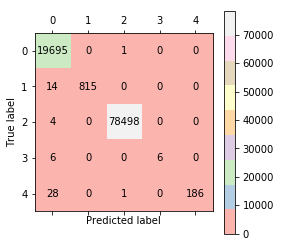

TypeError: calculatePrecision() missing 1 required positional argument: 'labels'

In [58]:
test_cm,test_true,test_pred = drawFromDF(dataset=test_result)

In [ ]:
correct_cm,correct_true,correct_pred = drawFromDF(dataset=correct_result)